In [1]:
# loading dataset
import json
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

In [2]:
df = (
    pd
    .read_json('../data/all_cleared_txts.jsonl', lines=True)
    .assign(
        id_num = lambda x: x.id.str.split('_', expand=True)[0],
        coursera_id = lambda x: x.id.str.split('_', expand=True)[1]
    )
    .pipe(lambda x: x[~x.text.duplicated()])
    .drop('coursera_id', axis=1)
    .reset_index()
)

In [3]:
df.shape

(24211, 5)

# Use CountVectorizer to get a bag of trigrams
This is a bag of words method where "words" are trigrams.

Various plagiarism detection algorithms work well with trigrams.

In [5]:
cv = CountVectorizer(
    analyzer='word',
    token_pattern=r'(?u)\b\w\w+\b',
    lowercase=True,
    strip_accents='ascii',
    stop_words=stopwords.words('english'),
    ngram_range=(3,3),
    binary=True, # return 1 for all non-zero counts
    )

In [6]:
tri_bow = cv.fit_transform(df['text'])
print(tri_bow.shape)
cv.get_feature_names_out()

(24211, 6065119)


array(['00 00 00', '00 00 000', '00 00 02', ...,
       'zyntra micro influencer', 'zyrardow distillery built',
       'zzzzz text text'], dtype=object)

# Compute cosine similarity between documents

While cosine Jaccard Similarity or Containment Score would be more ideal, these methods rely on pairwise comparisons O(N^2).

Cosine similarity is a computationally efficient approach that also measures the extent to which two documents have similar trigrams.

In [7]:
cosine_matrix = cosine_similarity(tri_bow)
# ignore identity comparisons
np.fill_diagonal(cosine_matrix, 0)
max_sims = np.amax(cosine_matrix, axis=0)
inds_of_max_sims = np.argmax(cosine_matrix, axis=0)
inds_of_max_sims

array([23260,  7823,  1206, ..., 20099, 21622, 20487])

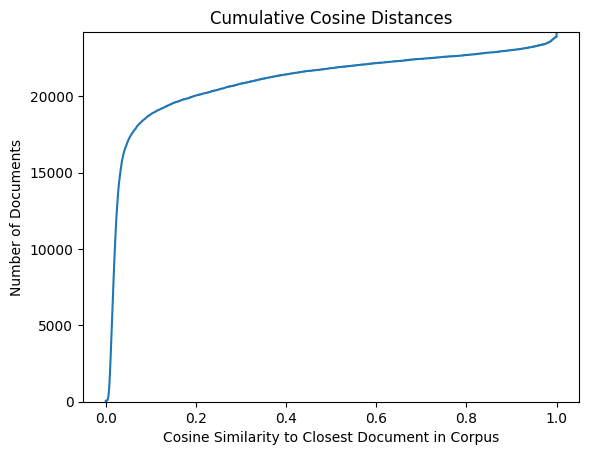

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

g = sns.ecdfplot(data=max_sims, stat='count')
g.set(title='Cumulative Cosine Distances',
      xlabel='Cosine Similarity to Closest Document in Corpus',
      ylabel='Number of Documents'
)
plt.show()

In [12]:
# This removes BOTH similar documents
deduplicated = df.drop(inds_of_max_sims[max_sims >= 0.9])

In [13]:
deduplicated.shape

(23390, 5)

# Apply Character-based Outlier Detection

We assume that docs with an unusual proportion of a given character (such as the letter e) may be poorly transcribed PDFs.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(
    analyzer='char',
    encoding='ascii',
    lowercase=False, # strip_accents applied after this, resulting in some uppercase letters. lowercase manually to avoid this.
    strip_accents='ascii',
    ngram_range=(1,1), # 1 character
    norm='l1',
    binary=False, # return counts of characters
)

In [15]:
char_tfidf = cv.fit_transform(deduplicated['text'])
char_tfidf.shape

(23390, 96)

In [16]:
print(len(cv.get_feature_names_out()))
cv.get_feature_names_out()

96


array(['\t', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
       ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
       'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
       'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
       '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z', '{', '|', '}', '~'], dtype=object)

In [17]:
char_distributions = pd.DataFrame(char_tfidf.toarray(), columns=cv.get_feature_names_out())

In [19]:
from itertools import chain

def plot_distributions():
    letter_ascii_codes = chain(range(65,91), range(97,123))
    punct_ascii_codes = chain(range(32,65), range(91,97))
    letter_dists = char_distributions[[chr(i) for i in letter_ascii_codes]].reset_index(names='id').melt(id_vars='id')
    punct_dists = char_distributions[[chr(i) for i in punct_ascii_codes]].reset_index(names='id').melt(id_vars='id')
    g = sns.FacetGrid(letter_dists, col='variable', col_wrap=4, sharex=False, sharey=False)
    g.map(sns.kdeplot, 'value', common_norm=True)
    g = sns.FacetGrid(punct_dists, col='variable', col_wrap=4, sharex=False, sharey=False)
    g.map(sns.kdeplot, 'value', common_norm=True)

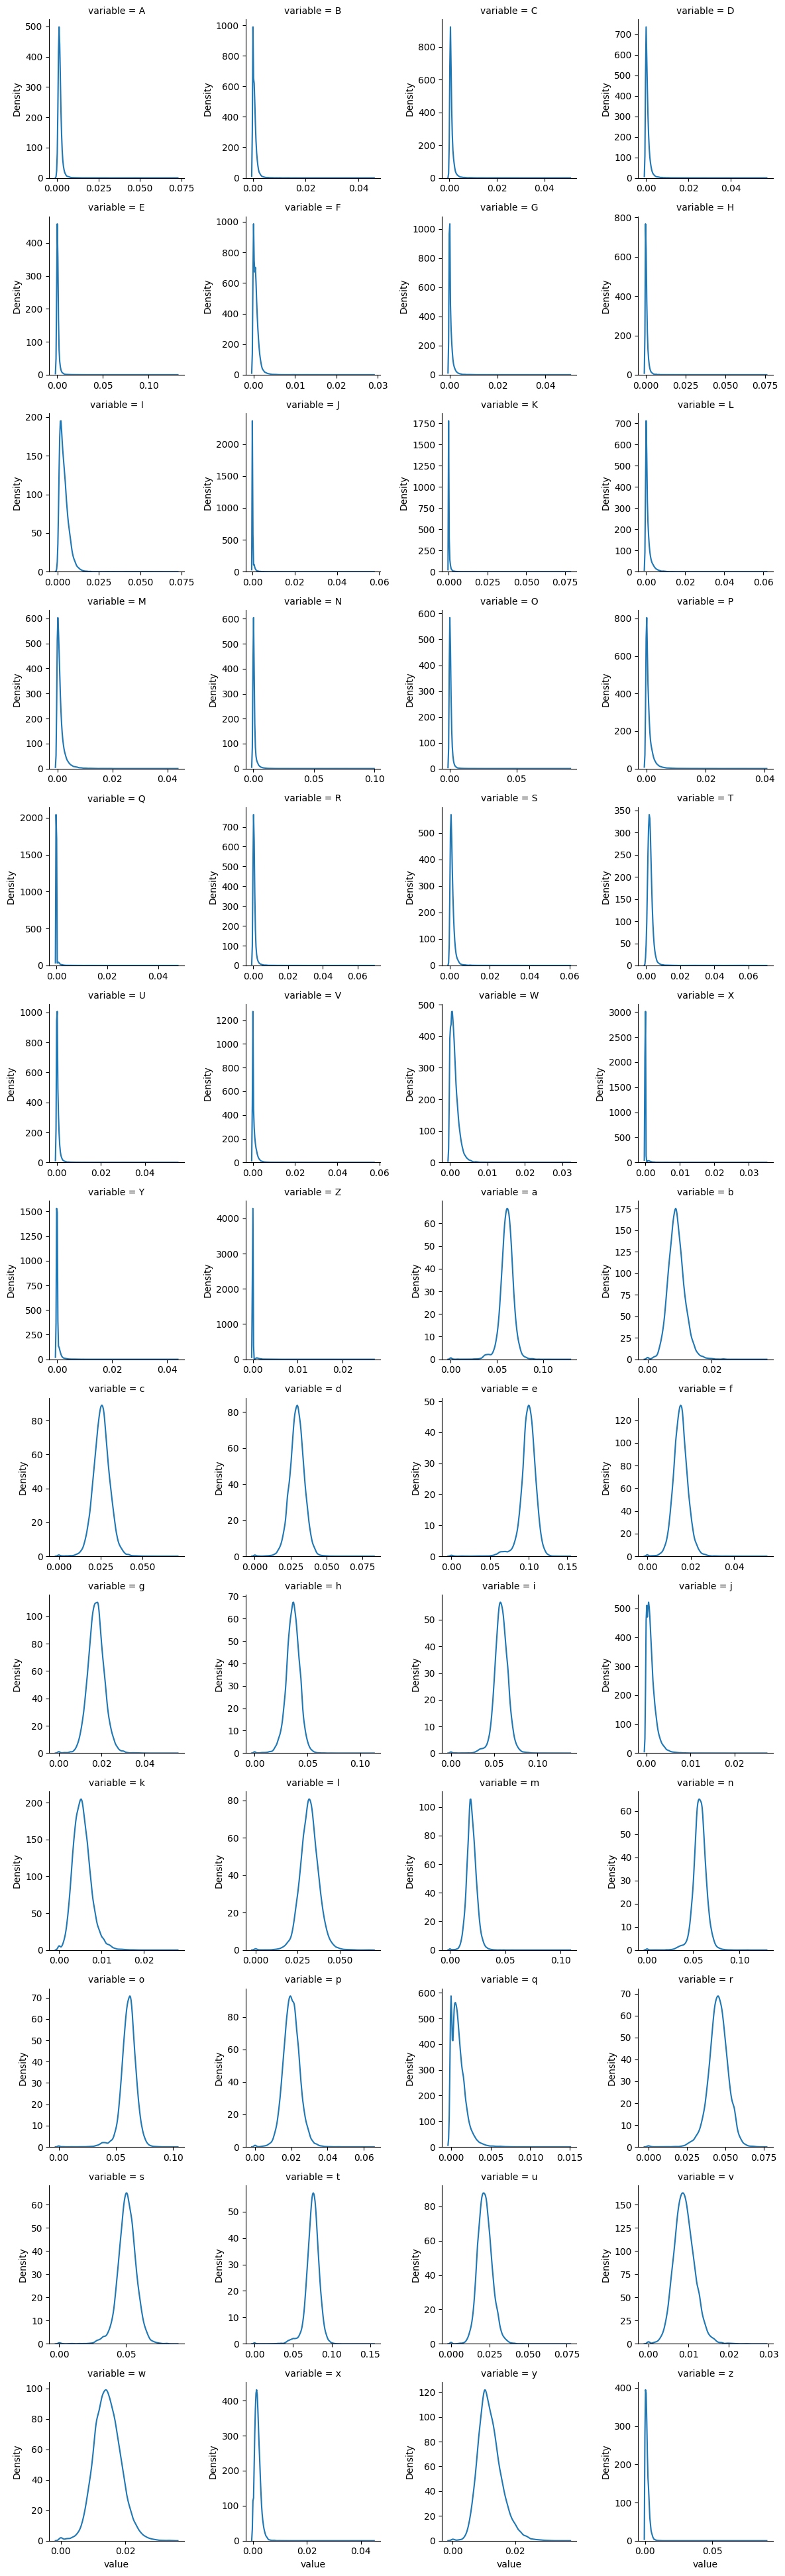

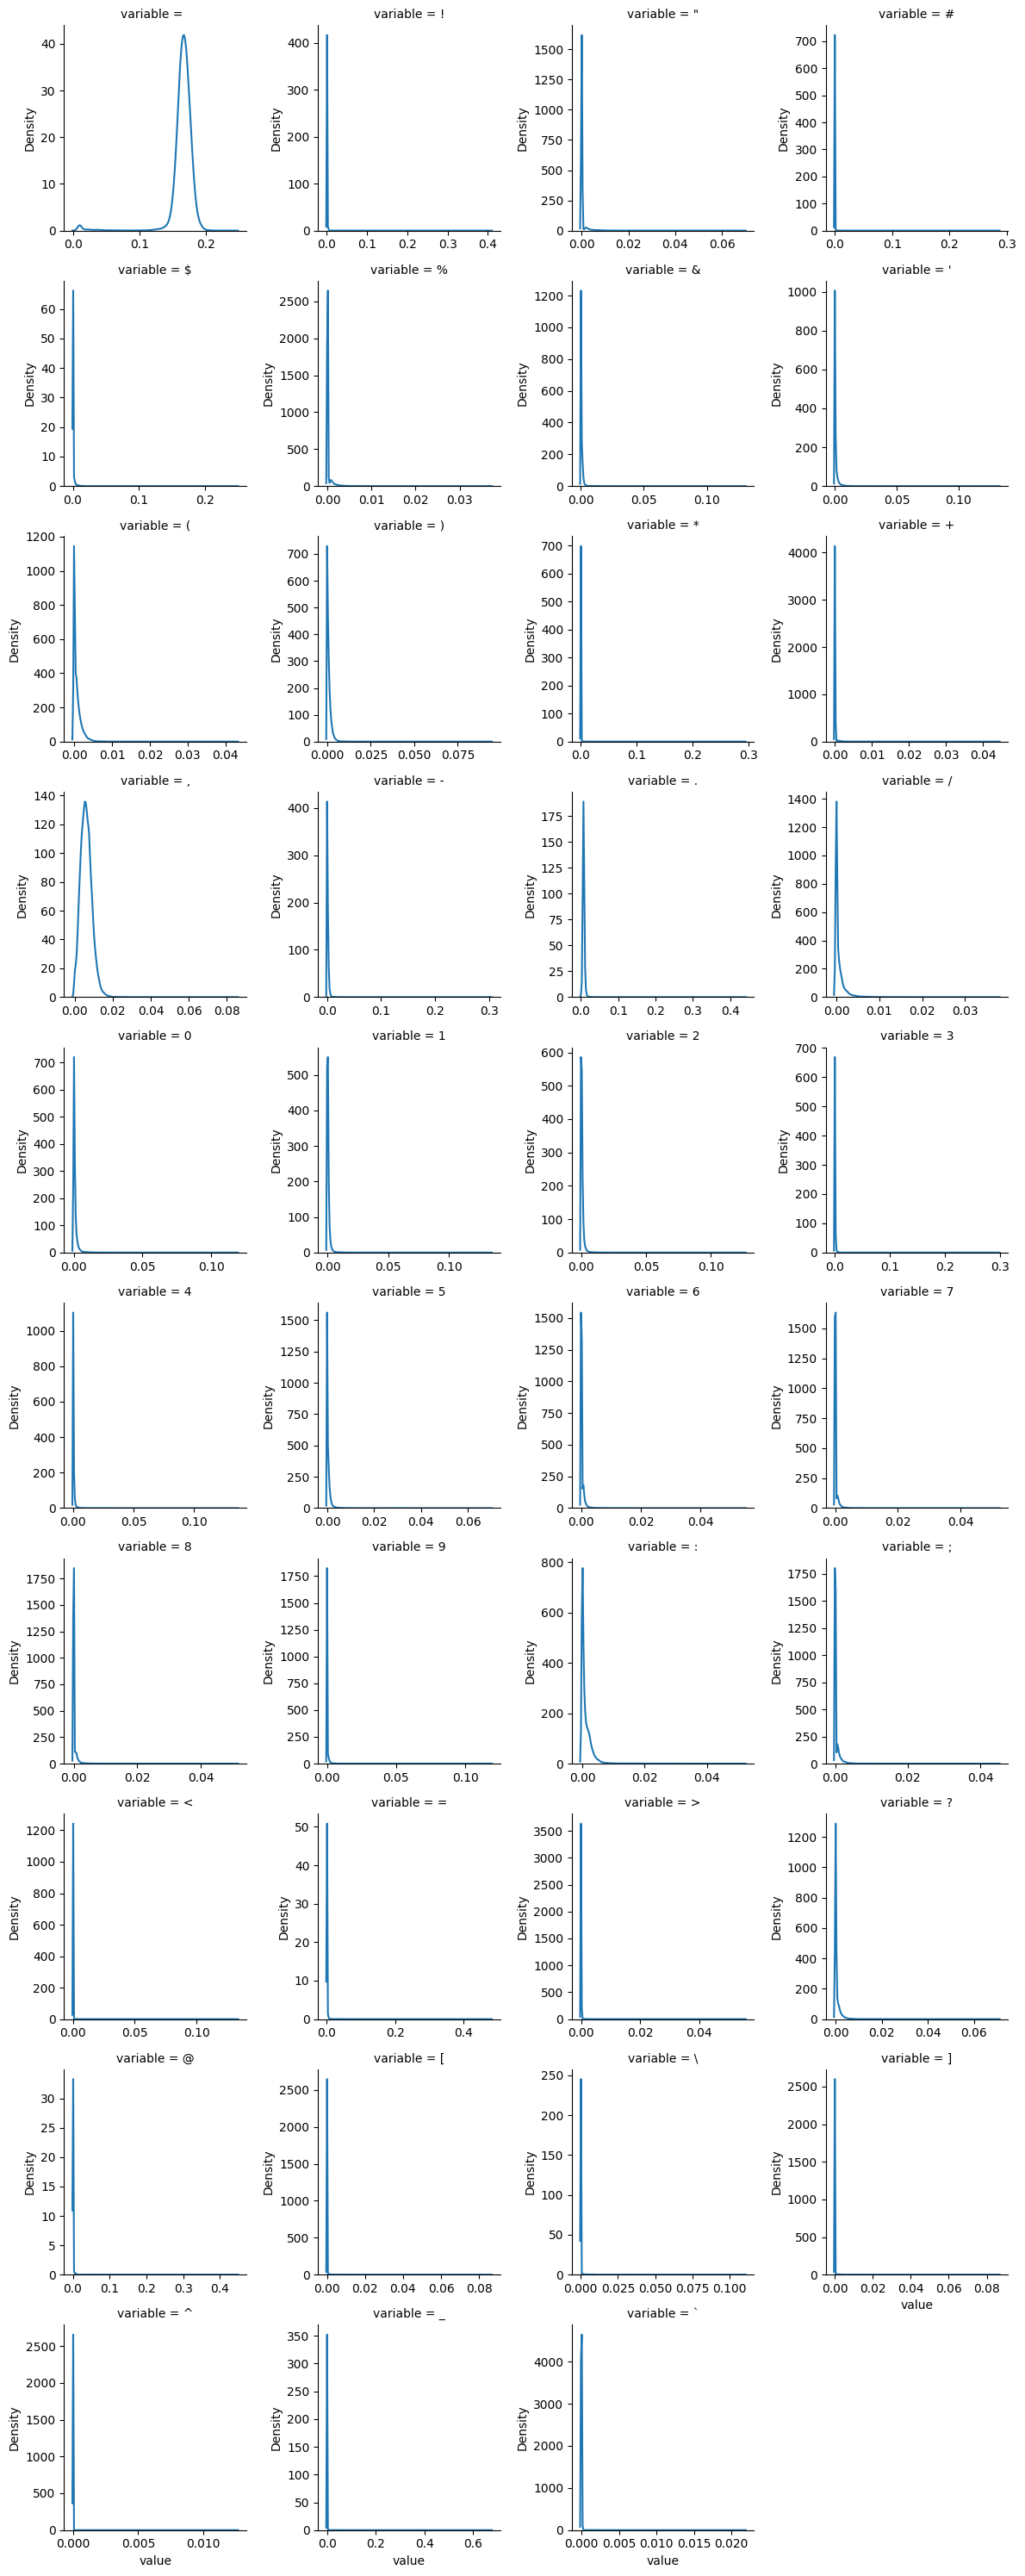

In [20]:
plot_distributions()

In [21]:
lowercase_and_space_codes = chain([32], range(97,123))
print(list(lowercase_and_space_codes))

[32, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]


In [22]:
lowercase_and_space_codes = chain([32], range(97,123))
lower_and_space_dists = char_distributions[[chr(i) for i in lowercase_and_space_codes]]

In [23]:
from sklearn.covariance import EllipticEnvelope

# clf = LocalOutlierFactor(n_neighbors=2, contamination=.001)
clf = EllipticEnvelope(contamination=.03)
inlier_indices = clf.fit_predict(lower_and_space_dists)
print(sum(inlier_indices==-1))

702


In [24]:
outliers = deduplicated.iloc[np.where(inlier_indices==-1)]['text']
inliers = deduplicated.iloc[np.where(inlier_indices==1)].drop(columns='index')

In [25]:
inliers.shape

(22688, 4)

In [ ]:
inliers.to_csv('../data/final_dataset.csv', index=False)

In [18]:
outliers.to_csv('../data/character_distribution_outliers.csv', index=False)

# Save in Batches for Upload

In [4]:
inliers = pd.read_csv('../data/final_dataset.csv')

In [ ]:
for i, df in enumerate(np.array_split(inliers, 40)):
    df.to_csv(f'../data/ubiai_uploads/batch_{i:02d}.csv', index=False)